In [1]:
#!/usr/bin/env python3

# Setup the notebook's environment
import lalsimulation as lalsim
from matplotlib.pyplot import *
from numpy import *
from positive import *
from nrutils import scsearch, gwylm
from glob import glob
import xcp
from xcp import determine_data_fitting_region,calibration_catalog,metadata_dict,template_amp_phase,gc,generate_model_params
from numpy.linalg import norm
from scipy.optimize import curve_fit
from os.path import exists

(positive)>> Applying custom matplotlib settings.
(init)>> Warm greetings from XCP.
(xcp.core)>> Catalog of calibration runs stored to "xcp.calibration_catalog"
(xcp.core)>> Metadata dictionary for calibration runs stored to "xcp.metadata_dict"
(xcp.core)>> Metadata dictionary for Ed's catalog paper stored to "xcp.catalog_paper_metadata"
(xcp.core)>> According to the global config, the XCP package is configured to model the [(2, 2), (3, 3)] coprecessing moment multipole moment(s)


In [2]:
# Let the user know where lalsimulation lives

#
lalsim_path = lalsim.__path__[0]
lalsuite_repo_path = lalsim_path.split('lib')[0]+'src/lalsuite/'
branch_name = bash('cd %s && git status'%lalsuite_repo_path).decode("utf-8").split('On branch ')[-1].split('\n')[0]

#
alert('We are getting our LALSimulation from:\n%s'%magenta(lalsim_path))
alert('We think that the related lalsuite source files are here:\n%s'%green(lalsuite_repo_path))
alert('Lastly, we are currently on this branch: %s'%bold(magenta(branch_name)))

#
if branch_name != 'pnrv1-ll':
    alert('We are not on the expected branch. This may cause unexpected behavior.',say=not True)

(notebook)>> We are getting our LALSimulation from:
/Users/book/opt/anaconda2/envs/hack-phenomx3/lib/python3.6/site-packages/lalsimulation
(notebook)>> We think that the related lalsuite source files are here:
/Users/book/opt/anaconda2/envs/hack-phenomx3/src/lalsuite/
(notebook)>> Lastly, we are currently on this branch: pnrv3-cp-bounded-dev
(notebook)>> We are not on the expected branch. This may cause unexpected behavior.


In [ ]:
qnmo_prograde = qnmobj( mf, abs(xf), l,m,0,p=1,use_nr_convention=True,verbose=False,calc_slm=False,calc_rlm=False )

(notebook)>> Loading parameter space data: (l,m) == (3,3)
(notebook)>> q2a02t120_T_96_384
(notebook)>> q2a02t150_T_96_384
(notebook)>> q2a04t150_T_96_408
(notebook)>> q2a04t120_T_96_408
(notebook)>> q2a04t90dPm1_T_96_408
(notebook)>> q2a04t60dPm1_T_96_408
(notebook)>> q2a04t30dPm2_T_96_408
(notebook)>> q2a02t30dP0dRm75_T_96_384
(notebook)>> q2a02t60dP0_T_96_384
(notebook)>> q2a02t90_T_96_384
(notebook)>> q4a02t90_T_96_384
(notebook)>> q4a02t120_T_96_384_amr_lmax14
(notebook)>> q4a02t150_new_T_96_384
(notebook)>> q4a04t150_T_96_360
(notebook)>> q4a04t120dP0D_T_96_360
(notebook)>> q4a04t90_T_96_360
(notebook)>> q4a04t60dPm1.5D_T_96_360
(notebook)>> q4a04t30_T_96_360
(notebook)>> q4a06t30dPm4_T_96_384
(notebook)>> q4a06t60dPm2_T_96_408
(notebook)>> q4a06t90dP0_T_96_408
(notebook)>> q4a06t120dP0.5_T_96_408
(notebook)>> q4a06t150_dP1_T_96_408_SHORT
(notebook)>> q4a08t150_T_96_360
(notebook)>> q4a08t120dP1_T_96_360
(notebook)>> q4a08t90dPm1D_T_96_384
(notebook)>> q4a08t60dPm3dRm250_T_96_384


ValueError: attempt to get argmin of an empty sequence

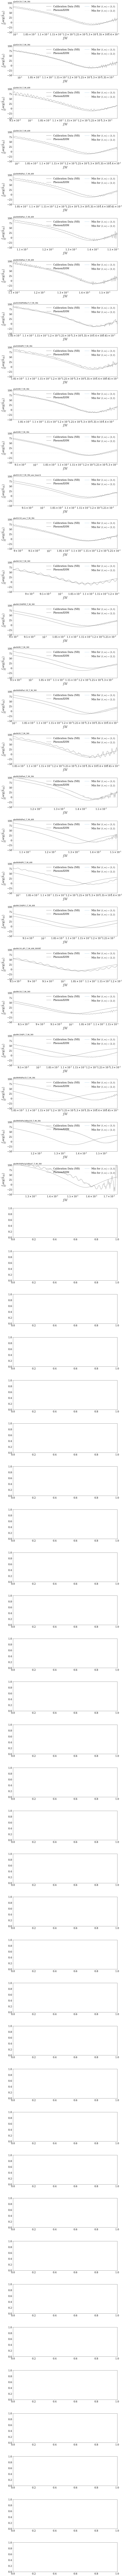

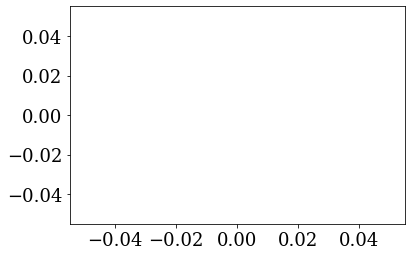

In [5]:
# For all pairs of l and m in the global config file
for ll,mm in [ lm for lm in gc.lmlist if lm != (2,2)]:

    # --------------------------------------- #
    # Preliminaries
    # --------------------------------------- #

    #
    alert('Loading parameter space data: (l,m) == (%i,%i)'%(ll,mm))

    # Define data location
    package_dir = parent( xcp.__path__[0] )
    datadir = package_dir + 'data/version4/'
    files = glob( datadir+'*_l%im%i.txt'%(ll,mm) )
    files.sort()
    # files = files[::-1]#
    
    # Ignore select files
    files = [ f for f in files if ('fit' not in f)  ]

    file_map = []
    for j,sn_ in enumerate(metadata_dict['simname']):
        
        # Find index location of this metadata in the list of file paths
        k = [ k for k,val in enumerate(files) if sn_ in val ][0]

        # 
        file_map.append(k)

    # Sort file paths like matadata so that we can then sort both according to distance between physical parameters
    files = array(files)[file_map]
    
    reference_index = 0
    # theta,m1,m2,eta,delta,chi_eff,chi_p,chi1,chi2,a1,a2,chi1_x,chi1_y,chi1_z,chi2_x,chi2_y,chi2_z
    mask = [0,3,9] # theta, eta, a1 -- the parameters that will be used to calculate distance for sorting
    coordinates = metadata_dict['array_data'][:,mask]
    coordinates[:,0] = cos(coordinates[:,0]) # use cos theta 
    index_map, sorted_coordinates = distance_sort( coordinates, reference_index, center=not False )

    #
    files = list(files[index_map]) 
    
    #
    if ll==3:
        files = [ f for f in files if ('q1' not in f)  ]

    # Load and unpack physical parameter space
    # NOTE that the order of these parameters must be the same as that in files
    # opt_parameter_range_22 = loadtxt(datadir+'fit_opt_parameters_l%im%i.txt'%(2,2))
    # opt_parameter_range = loadtxt(datadir+'fit_opt_parameters_l%im%i.txt'%(ll,mm))
    # scarecrow = template_amp_phase(0.5, 0.5,zeros(3),zeros(3),lm=(ll,mm))
    # parameter_names_in_order = scarecrow.__code__.co_varnames[1:scarecrow.__code__.co_argcount]
    # model_range = {  parameter_names_in_order[k]:var for k,var in enumerate(opt_parameter_range.T) }

    # #
    # fig,ax = subplots( 1, 1, figsize=3*array([ 2.5*1/(0.618), 1.5*1 ]) )
    # ax = array([ax])

    #
    fig,ax = subplots( len(files), 1, figsize=3*array([ 2.5*1/(0.618), 1.5*len(files) ]) )
    ax = ax.flatten()

    #
    tight_layout(w_pad=4,h_pad=4)

    #
    foo = {}

    #
    lmlist = [ (ll,mm) ]

    #
    p = 0
    # c0list = 
    shift_dict = {}
    for j,f_ in enumerate(files):

        #
        simname = f_.split('/')[-1].split('_l%im%i.'%(ll,mm))[0]

        # Find index location of metadata for simname 
        k = [ k for k,val in enumerate(metadata_dict['simname']) if val in simname ][0]

        # Load data for this case
        
        # --- (2,2)
        raw_data_22 = loadtxt(f_.replace('l%im%i'%(ll,mm),'l2m2')).T
        alert(simname)
        calibration_data_22, dphi_lorentzian_min_22, f_min_22, f_max_22, f_lorentzian_min_22 = determine_data_fitting_region( raw_data_22, simname=simname, lm=(ll,mm), floor_dphi=False, smooth_dphi=False )
        
        #
        # NOTE: smooth_dphi=True is set because data must be smoothed before the fitting region is selected in order to avoid smoothing related boundary effects 
        
        # --- (ll,mm)
        raw_data = loadtxt(f_).T
        # alert(simname)
        
        f0,f1 = f_min_22*0.5*ll, f_max_22*0.5*ll
        # if 'q8a04t150' in simname:
        #     f0 += 0.001
        # if 'q8a02t150' in simname:
        #     f0 += 0.001
        # if 'q8a02t120' in simname:
        #     f0 += 0.001
        if 'q2_a10_a28_ph0_th30' in simname:
            f1 -= 0.002
        elif 'q4a02t30' in simname:
            f1 -= 0.001
        elif 'q4a08t60' in simname:
            f1 -= 0.005
        elif 'q8a08t60' in simname:
            f1 -= 0.005
        elif 'q4a08t30' in simname:
            f1 -= 0.0015
            
        calibration_data, dphi_lorentzian_min, f_min, f_max, f_lorentzian_min = determine_data_fitting_region( raw_data, simname=simname, lm=(ll,mm), floor_dphi=False,f_lim=(f0,f1) )

        # Collect params for this case 
        metadata = metadata_dict['array_data'][k,:]

        #
        f_22,amp_fd_22,dphi_fd_22_raw,alpha_22,beta_22,gamma_22 = calibration_data_22.T
        f,amp_fd,dphi_fd_raw,alpha,beta,gamma = calibration_data.T
        
        #
        theta,m1,m2,eta,delta,chi_eff,chi_p,chi1,chi2,a1,a2,chi1_x,chi1_y,chi1_z,chi2_x,chi2_y,chi2_z = metadata_dict['array_data'][k]
        chi1_vec = array([chi1_x,chi1_y,chi1_z])
        chi2_vec = array([chi2_x,chi2_y,chi2_z])
        
        #
        action_helper_22 = template_amp_phase(m1, m2, chi1_vec, chi2_vec,lm=(2,2), option_shorthand='4-xhm',turn_on_relative_dphi_mode=True)
        action_helper = template_amp_phase(m1, m2, chi1_vec, chi2_vec,lm=(ll,mm), option_shorthand='4-xhm',turn_on_relative_dphi_mode=True)
        #
        mod_xhm0_amp_22,mod_xhm0_dphi_22,mod_xhm0_min_dphi_22 = action_helper_22(f)
        mod_xhm0_amp,mod_xhm0_dphi,mod_xhm0_min_dphi          = action_helper(f)
        
        # #
        # popt_22 = opt_parameter_range_22[j,:]
        # opt_amp_22,opt_dphi_22,min_dphi_22 = action_helper_22(f,*popt_22)
        # #
        # popt = opt_parameter_range[j,:]
        # opt_amp,opt_dphi,min_dphi = action_helper(f,*popt)
        
        
        # NOTE: smooth_dphi=True is set because data must be smoothed before the fitting region is selected in order to avoid smoothing related boundary effects. See code above.
        dphi_fd_22 = dphi_fd_22_raw  # smooth(dphi_fd_22_raw,width=20).answer
        dphi_fd    = dphi_fd_raw     # smooth(dphi_fd_raw,width=10).answer
        
        #
        shifted_mod_xhm0_dphi = mod_xhm0_dphi - mod_xhm0_min_dphi_22
        # shifted_opt_dphi = opt_dphi - min_dphi_22
        
        # ------------------------------- #
        df = f[1]-f[0]
        N = len(f)
        T = 1.0 / df
        shifted_dphi_fd = dphi_fd - dphi_lorentzian_min_22 # min(smooth(dphi_fd_22,width=20).answer)
        shifted_f_lorentzian_min = dphi_lorentzian_min - dphi_lorentzian_min_22 # min(smooth(dphi_fd,width=20).answer) - min(smooth(dphi_fd_22,width=20).answer)
        # print(dphi_lorentzian_min_22, ', ',min(dphi_fd_22) )
        # shifted_dphi_fd = dphi_fd - dphi_lorentzian_min_22
        # print('T   = ',T)
        # print('remainder = ',remainder( dphi_lorentzian_min - dphi_lorentzian_min_22, 4000))
        # ------------------------------- #
        
        # #
        # mod_xhm_dict = xcp.get_phenomxphm_coprecessing_multipoles( f,lmlist, m1, m2, chi1_vec, chi2_vec, option_shorthand='2-xphm' )
        # mod_xhm = mod_xhm_dict[ll,mm]
        # mod_xhm_amp = abs(mod_xhm)
        # mod_xhm_phi = unwrap( angle(mod_xhm) )
        # mod_xhm_dphi = spline_diff(f,mod_xhm_phi)
        # mod_xhm_dphi -= min( mod_xhm_dphi[ (f>0.03*ll*0.5)&(f<0.12*ll*0.5) ] )
        # # mod_xhm_dphi -= mean( mod_xhm_dphi )
        
        # #
        # tuned_xhm_dict = xcp.get_phenomxphm_coprecessing_multipoles( f,lmlist, m1, m2, chi1_vec, chi2_vec, option_shorthand='1-pnr' )
        # tuned_xhm = tuned_xhm_dict[ll,mm]
        # tuned_xhm_amp = abs(tuned_xhm)
        # tuned_xhm_phi = unwrap( angle(tuned_xhm) )
        # tuned_xhm_dphi = spline_diff(f,tuned_xhm_phi)
        # tuned_xhm_dphi -= min( tuned_xhm_dphi[ (f>0.03*ll*0.5)&(f<0.12*ll*0.5) ] )
        # # tuned_xhm_dphi -= mean( tuned_xhm_dphi )
        
        
        # ******************************** #
        # Determine the optimal offset such that PNR overlaps with the calibration data (shifted_dphi_fd)
        # opt_pnr_shift = mean(shifted_dphi_fd-shifted_opt_dphi)
        # shifted_opt_dphi
        # shifted_opt_dphi_final = shifted_opt_dphi + opt_pnr_shift
        # ******************************** #

        # PLOTTING
        # ---

        #
        sca(ax[p]); p+=1
        plot( f, shifted_dphi_fd, label='Calibration Data (NR)', lw=4, alpha=0.2, color='k' )
        # plot( f, shifted_opt_dphi, label='Direct Fit (PNR-prototype)', ls='-',lw=2,alpha=1,color='dodgerblue' )
        # plot( f, shifted_opt_dphi_final, label='Direct Fit (PNR-prototype, time shift optimized)', ls='-',lw=2,alpha=1,color='tab:red' )
        plot( f, shifted_mod_xhm0_dphi, label='PhenomXHM', ls='--',lw=1,alpha=1,color='k',zorder=-10 )
        axhline(shifted_f_lorentzian_min,ls='--',color='tab:blue',label=r'Min for $(\ell,m)=(%i,%i)$'%(ll,mm))
        # plot( f, tuned_xhm_dphi, label='End Model (PNR)', ls='-',lw=2,alpha=1,color='r' )
        # plot( f, py_dphi, label='End Model (PNR-py)', ls=':',lw=2,alpha=1,color='tab:orange' )
        # plot( f, mod_xhm_dphi, label='PhenomXPHM', ls='-',lw=2,alpha=0.85,color='m' )
        xscale('log')
        xlim( max(f)*0.7,max(f) )
        # xlim(lim(f,dilate=1.1,dilate_with_multiply=True))
        # ylim( limy(f, shifted_dphi_fd,dilate=0.1) )
        ylim(-50,100)
        axhline(0,ls=':', c='k',alpha=0.4,label=r'Min for $(\ell,m)=(%i,%i)$'%(2,2))
        title(simname,size=12,loc='left')
        legend(ncol=2,loc=1)
        ylabel(r'$\frac{d}{df}\arg(\tilde{h}_{%i%i})$'%(ll,mm))
        xlabel('$fM$')
        title(simname,loc='left',size=12)

        # sca(ax[p]); p+=1
        # plot( f, amp_fd, label='Calibration Data (NR)', lw=4, alpha=0.2, color='k' )
        # plot( f, opt_amp, label='Direct Fit (PNR-prototype)', ls='--',lw=2,alpha=1,color='dodgerblue' )
        # plot( f, tuned_xhm_amp, label='End Model (PNR)', ls='-',lw=2,alpha=1,color='r' )
        # plot( f, py_amp, label='End Model (PNR-py)', ls=':',lw=2,alpha=1,color='tab:orange' )
        # plot( f, mod_xhm_amp, label='PhenomXPHM', ls='-',lw=2,alpha=0.85,color='m' )
        # plot( f, mod_xhm0_amp, label='PhenomXHM', ls='--',lw=1,alpha=1,color='k',zorder=-10 )
        # yscale('log')
        # xscale('log')
        # legend(ncol=2)
        # ylim( limy(f, amp_fd,dilate=1.2) )
        # xlabel('$fM$')
        # ylabel(r'$|\tilde{h}_{%i%i}(f)|$'%(ll,mm))
        # #
        # title(simname,loc='left',size=12)
        
        #
        shift_dict[simname] = shifted_f_lorentzian_min
        
        # break
            
            
    #
    file_path = datadir+'time_shift_diagnostic_l%im%i.pdf'%(ll,mm)
    alert('Saving batch plot to %s'%magenta(file_path))
    savefig(file_path,pad_inches=2, bbox_inches = "tight")

    #
    data_path = datadir+'dphi_shift_dict_l%im%i.pickle'%(ll,mm)
    alert('Saving dphi_shift_dict to %s'%magenta(data_path))
    print('>> ',shift_dict)
    pickle.dump( shift_dict, open( data_path, "wb" ) )
        
    alert('Done.')